# **LSTM for Caption Generation**

Our goal is to implement an LSTM that receives feature vectors as the input and generates captions.

## Setup

In [1]:
import numpy as np
import random
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt

## Datasets
First, we examine the training data:

In [2]:
trData = h5py.File('eee443_project_dataset_train.h5','r')
print([key for key in trData.keys()])

#Captions for training images (contains 17 indices from the vocabulary for each image,note that a single image can have multiple captions provided by different observers)
train_cap = trData['train_cap'][:]
print('\ntrain_cap shape: ', train_cap.shape)
train_size, cap_size = train_cap.shape
tr_size = 40000 #If you don't want to train over the whole the dataset

#The indices of training images (since a single image can be captioned several times, this image index is required to relate each caption with the corresponding image) 
train_imid = trData['train_imid'][:]
print('\ntrain_imid shape: ', train_imid.shape)


#Pretrained feature vector for training images
train_ims = trData['train_ims'][:] 
print('\ntrain_ims shape: ', train_ims.shape)
feature_size = train_ims.shape[1]
feature_min, feature_max = np.min(train_ims), np.max(train_ims)

#dictionary for converting words to vocabulary indices
word_code = trData['word_code'][:]
word_ind = np.array(word_code.tolist())[0,:].astype(int) #Word indices
vocab = [name for name,typ in word_code.dtype.fields.items()] #Vocabulary 
print('\nMin word index:',np.min(word_ind),', Max word index:',np.max(word_ind))
dictionary_size = len(word_ind)

['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']

train_cap shape:  (400135, 17)

train_imid shape:  (400135,)

train_ims shape:  (82783, 512)

Min word index: 0 , Max word index: 1003


Now, we form the training input & target for LSTM:
 - The inputs are the feature vectors;
 - For each input, the target is a sequence of the form $ d[n]\in \mathbb{R}^{1\times|{\rm dictionary}|} $, $n = 0:|{\rm caption}|-1$, where $d[n]$ is the one-hot encoding of the $n$-th word index in the given target caption. 

In [3]:
tr_shuffle = random.sample(range(train_size), tr_size) #for randomly shuffling the training set
X_tr = np.zeros((tr_size, feature_size))
Y_tr = np.zeros((tr_size, cap_size, dictionary_size), dtype = 'int32')
for n in range(tr_size):
    X_tr[n, :] = 2*(train_ims[train_imid[tr_shuffle[n]]-1,:] - feature_min)/(feature_max - feature_min) - 1
    Y_tr[n, range(cap_size), train_cap[tr_shuffle[n],:]] = 1   
print(np.min(X_tr), np.max(X_tr))    

-0.9738134741783142 1.0


## Defining & Building the LSTM Network

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Softmax, Dense, LSTM, RepeatVector, Dropout
from tensorflow.keras.initializers import GlorotUniform

sequence_size = cap_size #Lengths of LSTM input & output sequences
n_lstm = [256, 512] #Number of LTSM neurons
initializer = GlorotUniform() #Xavier initializer

#Building the model for caption generator network
model_capgen = Sequential()
model_capgen.add(RepeatVector(sequence_size))
model_capgen.add(LSTM(n_lstm[0], return_sequences=True, time_major=False, kernel_initializer=initializer))
model_capgen.add(Dropout(0.1))
model_capgen.add(LSTM(n_lstm[1], return_sequences=True, time_major=False, kernel_initializer=initializer))
model_capgen.add(Dropout(0.2))
model_capgen.add(Dense(1028, activation='tanh', kernel_initializer=initializer))
model_capgen.add(Dropout(0.2))
model_capgen.add(Dense(dictionary_size, kernel_initializer=initializer))
model_capgen.add(Softmax())

#Compile the model
model_capgen.compile( optimizer = 'adam', 
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])


## Training the LSTM Network

In [5]:
batchSize = 64 #Batch size
epochMax = 20 #No. of epochs

#Allow early stoppage based on the validation accuracy
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_accuracy', patience=2, mode="auto", verbose=1)

history = model_capgen.fit(X_tr,
                           Y_tr,
                           batch_size = batchSize,
                           epochs = epochMax,
                           verbose = 1,
                           validation_split = 0.15,
                           callbacks = [callback])


Train on 34000 samples, validate on 6000 samples
Epoch 1/20
34000/34000 [==============================] - 783s 23ms/sample - loss: 3.2008 - accuracy: 0.4305 - val_loss: 3.0695 - val_accuracy: 0.4444
Epoch 2/20
34000/34000 [==============================] - 762s 22ms/sample - loss: 2.9849 - accuracy: 0.4439 - val_loss: 2.9100 - val_accuracy: 0.4463
Epoch 3/20
34000/34000 [==============================] - 757s 22ms/sample - loss: 2.8825 - accuracy: 0.4455 - val_loss: 2.8436 - val_accuracy: 0.4508
Epoch 4/20
34000/34000 [==============================] - 751s 22ms/sample - loss: 2.8281 - accuracy: 0.4470 - val_loss: 2.8051 - val_accuracy: 0.4508
Epoch 5/20
34000/34000 [==============================] - 728s 21ms/sample - loss: 2.7946 - accuracy: 0.4485 - val_loss: 2.7727 - val_accuracy: 0.4533
Epoch 6/20
34000/34000 [==============================] - 727s 21ms/sample - loss: 2.7758 - accuracy: 0.4489 - val_loss: 2.7578 - val_accuracy: 0.4525
Epoch 7/20
34000/34000 [=====================

Let's visualize the training results:

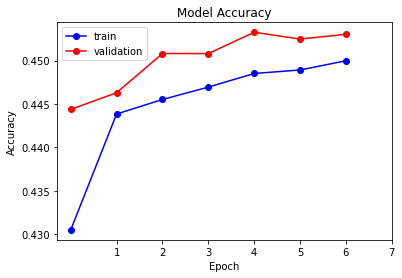

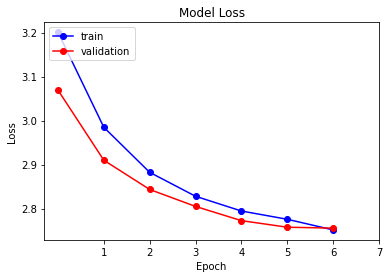

In [6]:
#Accuracy over epochs
plt.plot(history.history['accuracy'], marker = 'o', color = 'blue')
plt.plot(history.history['val_accuracy'], marker = 'o', color = 'red')
plt.xticks(range(1,1+len(history.history['loss'])))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Loss over epochs
plt.plot(history.history['loss'], marker = 'o', color = 'blue')
plt.plot(history.history['val_loss'], marker = 'o', color = 'red')
plt.xticks(range(1,1+len(history.history['loss'])))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Testing the LSTM Network

Let's load the test dataset:

In [7]:
tstData = h5py.File('eee443_project_dataset_test.h5','r')
print([key for key in tstData.keys()])

test_cap = tstData['test_caps'][:]
test_imid = tstData['test_imid'][:]
test_ims = tstData['test_ims'][:]
tst_no = test_ims.shape[0] #No. of test images

test_size = test_cap.shape[0]
tst_size = 10000 #If you don't want to use the whole dataset
tstf_min, tstf_max = np.min(test_ims), np.max(test_ims)

tst_shuffle = random.sample(range(test_size), tst_size) #for randomly shuffling the test set
X_tst = np.zeros((tst_size, feature_size))
Y_tst = np.zeros((tst_size, cap_size, dictionary_size), dtype = 'int32')
for n in range(tst_size):
    X_tst[n, :] = 2*(test_ims[test_imid[tst_shuffle[n]]-1,:]-tstf_min)/(tstf_max-tstf_min) - 1
    Y_tst[n, range(cap_size), test_cap[tst_shuffle[n],:]] = 1

['test_caps', 'test_imid', 'test_ims', 'test_url']


Now, we evaluate the trained LSTM:

In [8]:
score = model_capgen.evaluate(X_tst,
                              Y_tst,
                              batch_size = 64)

10000/10000 [==============================] - 67s 7ms/sample - loss: 3.0947 - accuracy: 0.4427


## Saving the Results
Let's save the trained model as well as training & testing results for (possible) future reference:

In [9]:
model_capgen.save('LSTM_trained_model.h5')

hf = h5py.File('LSTM_results.h5','w')
hf.create_dataset('accuracy', data = history.history['accuracy'])
hf.create_dataset('loss', data = history.history['loss'])
hf.create_dataset('val_accuracy', data = history.history['val_accuracy'])
hf.create_dataset('val_loss', data = history.history['val_loss'])
hf.create_dataset('score', data = score)

<HDF5 dataset "score": shape (2,), type "<f8">

## Sample Captions

Let's generate some captions with our model:

In [10]:
rand_sel = random.sample(range(tst_no), 10)
for kr in rand_sel:
    Yout = model_capgen.predict(np.reshape(train_ims[kr,:],(1,-1)), batch_size = 1)
    caption_gen = [vocab[np.argmax(Yout[0,i,:])] for i in range(cap_size)]
    print('\nCaption for Test Image No.', kr)
    print(' '.join(str(x) for x in caption_gen))


Caption for Test Image No. 38629
all skis chair row skis skis skis skis skis skis skis skis skis skis skis skis skis

Caption for Test Image No. 28094
all all all all all all all all all all all all all all all all all

Caption for Test Image No. 39302
all all skis all all all all all all all all all all all all all all

Caption for Test Image No. 10819
all skis wave yellow young young yellow yellow yellow yellow yellow yellow yellow young young young young

Caption for Test Image No. 31957
all skis skis all all skis all all all all all all all all all all shop

Caption for Test Image No. 25371
all skis street skis skis skis skis skis skis skis skis skis skis street street street street

Caption for Test Image No. 28252
all skis pointing skis skis skis skis skis skis skis skis skis skis skis skis skis skis

Caption for Test Image No. 32259
all skis ride yellow skis skis skis skis skis skis skis skis skis skis skis skis skis

Caption for Test Image No. 34777
all all all all all all all